In [1]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, auc
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, StandardScaler

In [4]:
# load the clean dataset
churn_df = pd.read_csv('../data/churn_cleaned.csv')
churn_df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,16,128,415,1926,NaN,NaN,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,1575,NaN,NaN,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,1117,NaN,NaN,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,1707,NaN,NaN,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,110,NaN,NaN,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [5]:
# # define X and y variables
X = churn_df.drop(columns='churn', axis=1)
y = churn_df['churn']

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # scale the train and test features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# display the shape of thr train and test sets
print("Shape of scaled X_train:", X_train.shape)
print("Shape of scaled X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of scaled X_train: (2666, 20)
Shape of scaled X_test: (667, 20)
Shape of y_train: (2666,)
Shape of y_test: (667,)


In [6]:
# instantiate a Decision Tree model
dec_model = DecisionTreeClassifier()

# fit the training data
dec_model.fit(X_train, y_train)

# model prediction on the test dataset
y_pred_dec = dec_model.predict(X_test)

# compute the accuracy and display classification report
dec_acc = accuracy_score(y_test, y_pred_dec)
print("Decision Tree model accuracy:", dec_acc)

dec_report = classification_report(y_true=y_test, y_pred=y_pred_dec)
print(dec_report)

Decision Tree model accuracy: 0.8620689655172413
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       566
           1       0.54      0.64      0.59       101

    accuracy                           0.86       667
   macro avg       0.74      0.77      0.75       667
weighted avg       0.87      0.86      0.87       667



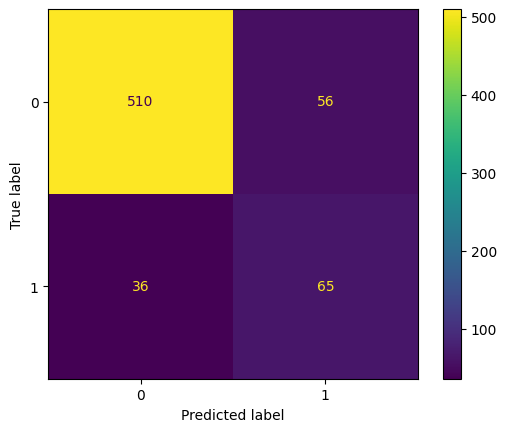

In [7]:
# compute the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_dec)
conf_matrix

# plot the confusion matrix
conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dec_model.classes_)
conf_disp.plot()

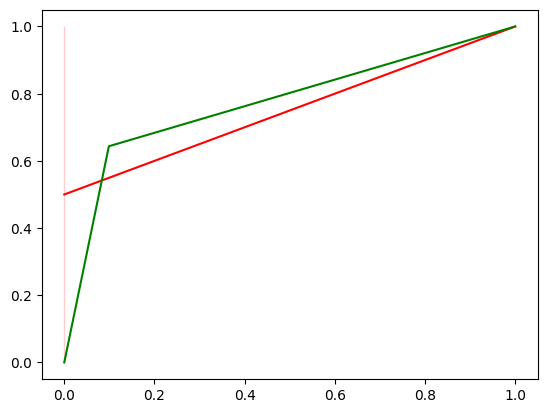

In [10]:
# define the train false positive and true positive rates
fpr_train, tpr_train, thres = roc_curve(y_true=y_train, y_score=dec_model.predict_proba(X_train)[:, 1])

# define the test false positive and true positive rates
fpr_test, tpr_test, _ = roc_curve(y_true=y_test, y_score=dec_model.predict_proba(X_test)[:, 1])

# plot the ROC curve
sns.lineplot(x=fpr_train, y=tpr_train, color="red")
sns.lineplot(x=fpr_test, y=tpr_test, color="green")
plt.show();

In [15]:
# compute the AUC score
auc_score_dec = auc(fpr_test, tpr_test)
auc_score_dec

np.float64(0.7723122135535109)

In [11]:
# check the general info of the decision tree
tree_info = dec_model.tree_
num_nodes = tree_info.node_count
num_leaves = tree_info.n_leaves
num_decision = num_nodes - num_leaves

print("Number of nodes:", num_nodes)
print("Number of leaves:", num_leaves)
print("Number of decision:", num_decision)

Number of nodes: 435
Number of leaves: 218
Number of decision: 217


In [12]:
# hyperparameter tuning for decision tree model
param_grid_dec = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# define the GridSearchCV function
grid_model_dec = GridSearchCV(dec_model, param_grid=param_grid_dec, cv=5, verbose=True, scoring='accuracy')

# fit the training data and obtain optimal hyperparameters
grid_model_dec.fit(X_train, y_train)
print("Optimal model hyperparameters:", grid_model_dec.best_params_)
print("Best model accuracy:", grid_model_dec.best_score_)
print("Best model estimators:", grid_model_dec.best_estimator_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Optimal model hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best model accuracy: 0.9084821271721791
Best model estimators: DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=10)


In [14]:
# update the decision tree model with the optimal hyperparameters
dec_model_tuned = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=2, 
    min_samples_split=10
)
dec_model_tuned.fit(X_train, y_train)
y_pred_dec_tuned = dec_model_tuned.predict(X_test)
dec_acc_tuned = accuracy_score(y_test, y_pred_dec_tuned)
print("Tuned Decision Tree model accuracy:", dec_acc_tuned)

dec_tuned_report = classification_report(y_true=y_test, y_pred=y_pred_dec_tuned)
print(dec_tuned_report)

Tuned Decision Tree model accuracy: 0.9070464767616192
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       566
           1       0.84      0.48      0.61       101

    accuracy                           0.91       667
   macro avg       0.88      0.73      0.78       667
weighted avg       0.90      0.91      0.90       667

